# Study of bias in adult Census dataset

## Litterature review

### Fairness Beyond Disparate Treatment & Disparate Impact : Learning Classification without Disparate Mistreatment

This research paper presents a large-scale study on gender bias in occupation classification using machine learning. The study analyzes the impact of including explicit gender indicators in semantic representations of online biographies on occupation classification. The researchers created a new dataset of online biographies and used three different semantic representations (bag-of-words, word embeddings, and deep recurrent neural networks) to predict people's occupations. They considered two scenarios: one with explicit gender indicators and one without. The study found that including explicit gender indicators increased the true positive rates (TPR) for certain occupations associated with specific genders. This means that the occupation classifiers were more accurate in identifying the occupations of individuals when explicit gender indicators were present. However, even when these indicators were removed or "scrubbed" from the representations, significant TPR gender gaps remained. This indicates that gender bias still existed in the occupation classifiers, suggesting that the classifiers were more likely to correctly predict the occupation of individuals of one gender compared to individuals of the other gender. Furthermore, the study found that these TPR gender gaps were correlated with existing gender imbalances in occupations. This means that occupations with a greater gender imbalance were more likely to have larger TPR gender gaps. This suggests that occupation classifiers may compound existing gender imbalances by reinforcing the underrepresentation of certain genders in specific occupations. The researchers also analyzed proxy behavior that occurs in the absence of explicit gender indicators. They found that certain words, such as "women," were highly predictive of gender even when gender indicators were removed. This indicates that gender information is not entirely removed by "scrubbing" explicit gender indicators, and that proxy behaviors can still perpetuate gender bias in occupation classification. Based on their findings, the study concludes that simply "scrubbing" explicit gender indicators is not sufficient to remove gender bias from occupation classifiers. More comprehensive approaches are needed to address gender bias, especially considering the existing gender imbalances in occupations. The study emphasizes the importance of designing and regulating occupation classifiers to prevent them from compounding gender imbalances and perpetuating gender bias. Overall, this research highlights the significance of addressing and mitigating bias in machine learning systems, particularly in high-stakes domains such as online recruiting and automated hiring. It demonstrates that fairness can be achieved without sacrificing performance, and provides insights into the complexities and challenges of combating gender bias in occupation classification.

### Survey of Bias in Machine Learning Through the Prism of Statistical Parity

We focused on a specific fairness criterion, the statistical parity, which is measured through the disparate impact
Fairness is achieved when the algorithm behaves in the same way for both groups; when the sensitive variable does not play a significant role in the prediction
It is made very clear from the outset that the aim of the article is to present a detailed analysis of the different approaches that have been proposed in the literature to study potential fairness issues in the binary classification problem through the adult income dataset
We first point out that testing methods focus on individual fairness while statistical methods such as the Disparate Impact Analysis tackle the issue of group fairness
As the rules considered are three of the best-known ML algorithms (LR, decision tree (DT), and GB) the explanations given on the proposed strategies have been brief and concise. We realize that this dataset can be considered as a toy example compared to the large databases that are generated and used nowadays by big and powerful multinationals, such as Amazon or Netflix mentioned in the introduction. It has been extensively studied in the literature on fairness in ML and we are well aware of the numerous solutions that have been proposed to solve this issue.
We bring the following take-home messages: (i) Bias in the training data may lead to ML algorithms taking unfair decisions, but not always
While, in this widely studied dataset, there was a clear increase of bias using the tested ML algorithms with respect to the gender variable, the ethnic origin did not lead in this case to a severe bias.
For this reason, as mentioned above, we have focused in the rest of the article on the protected variable gender. These discriminations are more severe for the gender variable than for the ethnic origin variable.

We proposed an ad hoc construction of confidence intervals for the disparate impact. (iii) Standard regulations that promote either the removal of the sensitive variable or the use of testing techniques appeared as irrelevant when dealing with fairness as statistical parity of ML algorithms.
We believe this is crucial in order to guarantee a fair treatment for every subgroup of population, which will contribute to reduce the growing distrust of ML systems in the society.

## Introduction
We will use in this notebook the Adult Income dataset, which is available on the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/adult). It consists in forecasting a binary variable (low or high income) which corresponds to an income lower or higher to 50k$ a year. This decision could be used to evaluate the credit risk and is considered here as sensitive to a discrimination. The variables X, and the true outcome Y are available, hence supervised machine learning algorithms will be used.

A total amount of 48.842 individuals are described by 14 variables.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

import warnings

# Filter out all user warnings
warnings.filterwarnings("ignore", category=UserWarning)

original_data_train = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "OrigEthn", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")

original_data_test = pd.read_csv(
    "data/adult.test",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "OrigEthn", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
    sep=r'\s*,\s*',
    engine='python',
    na_values="?")


original_data = pd.concat([original_data_test,original_data_train])
original_data.reset_index(inplace = True, drop = True)

original_data.tail()



,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,OrigEthn,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
48838,27,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
48839,40,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
48840,58,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
48841,22,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K
48842,52,Self-emp-inc,287927.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024.0,0.0,40.0,United-States,>50K


In [45]:
data=original_data.copy()


data['Child'] = np.where(data['Relationship']=='Own-child', 'ChildYes', 'ChildNo')
data['OrigEthn'] = np.where(data['OrigEthn']=='White', 'CaucYes', 'CaucNo')
data['Age'] = pd.to_numeric(data['Age'],errors='coerce')

data=data.drop(columns=['fnlwgt','Relationship','Country','Education'])

data=data.replace('<=50K.','<=50K')
data=data.replace('>50K.','>50K')

data.tail()


,Age,Workclass,Education-Num,Martial Status,Occupation,OrigEthn,Sex,Capital Gain,Capital Loss,Hours per week,Target,Child
48838,27.0,Private,12.0,Married-civ-spouse,Tech-support,CaucYes,Female,0.0,0.0,38.0,<=50K,ChildNo
48839,40.0,Private,9.0,Married-civ-spouse,Machine-op-inspct,CaucYes,Male,0.0,0.0,40.0,>50K,ChildNo
48840,58.0,Private,9.0,Widowed,Adm-clerical,CaucYes,Female,0.0,0.0,40.0,<=50K,ChildNo
48841,22.0,Private,9.0,Never-married,Adm-clerical,CaucYes,Male,0.0,0.0,20.0,<=50K,ChildYes
48842,52.0,Self-emp-inc,9.0,Married-civ-spouse,Exec-managerial,CaucYes,Female,15024.0,0.0,40.0,>50K,ChildNo


The following figure shows the dataset distribution per variable. We first notice the very unequal ditributions bewteen different features, like education and capital.

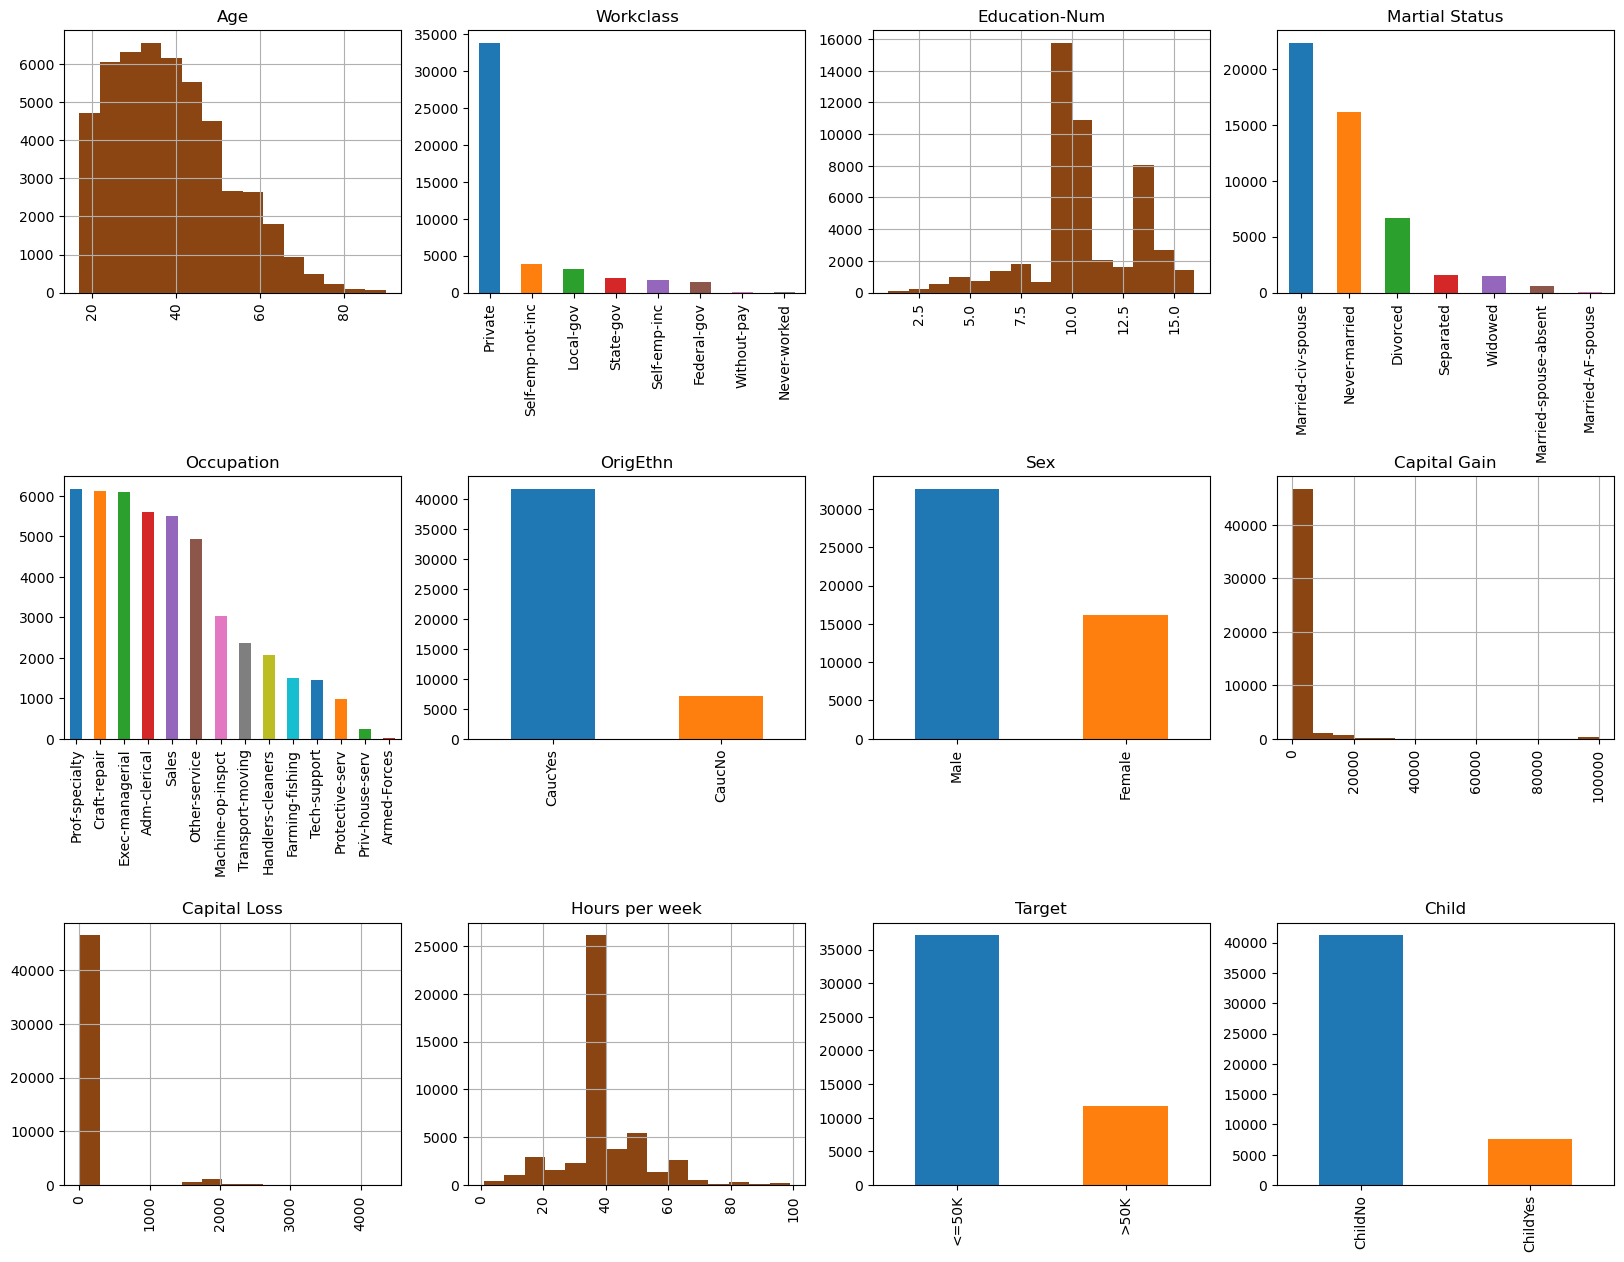

In [53]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(20,15))
cols = 4
rows = np.ceil(float(data.shape[1]) / cols)
for i, column in enumerate(data.columns):
    ax = fig.add_subplot(int(rows), cols, i + 1)
    ax.set_title(column)
    if data.dtypes[column] == object:
        data[column].value_counts().plot(kind="bar", axes=ax, color = colors.TABLEAU_COLORS)
    else:
        data[column].hist(axes=ax, bins = 15, color = 'saddlebrown')
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

The following figure displays the existing unbalance between sexes in the repartition of the target variable.

Mosaic plot:


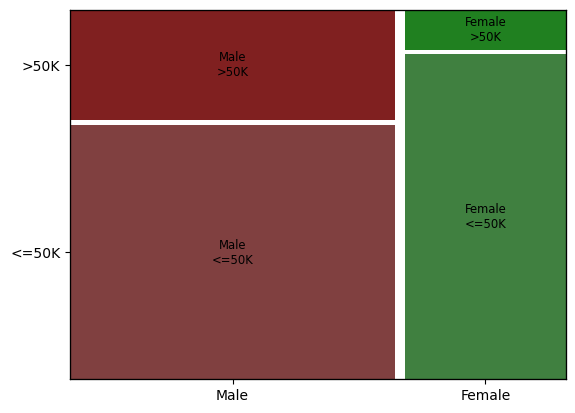

In [34]:
from statsmodels.graphics.mosaicplot import mosaic

print('Mosaic plot:')
mosaic(data, ['Sex','Target'],gap=0.02)
plt.savefig('figbias1.pdf')
plt.show()

### Preprocessing

In [35]:
data_ohe=data.copy()

data_ohe['Target'] = np.where(data_ohe['Target']=='>50K', 1., 0.)
print(' -> In column Target: label >50K gets 1.')

data_ohe['OrigEthn'] = np.where(data_ohe['OrigEthn']=='CaucYes', 1., 0.)
print(' -> In column '+str('OrigEthn')+': label '+str('CaucYes')+' gets 1.')

data_ohe['Sex'] = np.where(data_ohe['Sex']=='Male', 1., 0.)
print(' -> In column '+str('Sex')+': label '+str('Male')+' gets 1.')

for col in ['Workclass', 'Martial Status', 'Occupation', 'Child']:
    if len(set(list(data_ohe[col])))==2:
        LabelThatGets1=data_ohe[col][0]
        data_ohe[col] = np.where(data_ohe[col]==LabelThatGets1, 1., 0.)
        print(' -> In column '+str(col)+': label '+str(LabelThatGets1)+' gets 1.')
    else:
        print(' -> In column '+str(col)+': one-hot encoding conversion with labels '+str(set(list(data_ohe[col]))))
        data_ohe=pd.get_dummies(data_ohe,prefix=[col],columns=[col])

data_ohe.tail()

data_ohe=data_ohe.iloc[1:]

 -> In column Target: label >50K gets 1.
 -> In column OrigEthn: label CaucYes gets 1.
 -> In column Sex: label Male gets 1.
 -> In column Workclass: one-hot encoding conversion with labels {'Self-emp-inc', 'Without-pay', 'Local-gov', 'State-gov', None, 'Self-emp-not-inc', 'Private', nan, 'Federal-gov', 'Never-worked'}
 -> In column Martial Status: one-hot encoding conversion with labels {'Never-married', 'Widowed', 'Married-civ-spouse', 'Divorced', None, 'Separated', 'Married-spouse-absent', 'Married-AF-spouse'}
 -> In column Occupation: one-hot encoding conversion with labels {'Armed-Forces', 'Farming-fishing', 'Tech-support', None, 'Transport-moving', 'Machine-op-inspct', 'Other-service', 'Prof-specialty', 'Protective-serv', 'Craft-repair', 'Sales', 'Priv-house-serv', nan, 'Exec-managerial', 'Handlers-cleaners', 'Adm-clerical'}
 -> In column Child: label ChildNo gets 1.


In [7]:
#extract the X and y np.arrays
y=data_ohe['Target'].values.reshape(-1,1)

data_ohe_wo_target=data_ohe.drop(columns=['Target'])

X_col_names=list(data_ohe_wo_target.columns)
X=data_ohe_wo_target.values


#split the learning and test samples
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#print the np.array shapes 
print('n_train=',X_train.shape[0])
print('n_test=',X_test.shape[0])
print('p=',X_test.shape[1])

#center-reduce the arrays X_train and X_test to make sure all variables have the same scale
X_train=sk.preprocessing.scale(X_train)
X_test_NoScaling=X_test.copy()
X_test=sk.preprocessing.scale(X_test)

n_train= 32724
n_test= 16118
p= 37


In [8]:
#extract the X and y np.arrays
y=data_ohe['Target'].values.reshape(-1,1)

data_ohe_wo_target=data_ohe.drop(columns=['Target'])

X_col_names=list(data_ohe_wo_target.columns)
X=data_ohe_wo_target.values


#split the learning and test samples
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#print the np.array shapes 
print('n_train=',X_train.shape[0])
print('n_test=',X_test.shape[0])
print('p=',X_test.shape[1])

#center-reduce the arrays X_train and X_test to make sure all variables have the same scale
X_train_NoScaling=X_train.copy()
X_train=sk.preprocessing.scale(X_train)
X_test_NoScaling=X_test.copy()
X_test=sk.preprocessing.scale(X_test)

n_train= 32724
n_test= 16118
p= 37


## Measuring Bias

Different definitions of bias in a data set or induced by the decisions of an algorithm have been proposed in the statistical litterature. Among them we will consider the so-called demographic parity.

Consider the following notations:

- $Y$ is the variable to be forecast or explained. We consider here binary variables where $Y=1$ is a positive decision (<i.e.</i> a high income) while $Y=0$ is a low income;
- $g(X)=\hat{Y}$ is the prediction given by the algorithm. It can be either a score or a binary variable, small scores leading to the forecast $\hat{Y}=0$ while larger scores entail $\hat{Y}=1$.
- $S$ is the variable which divides the population into groups that may be treated in a different way, hence inducing a bias. From a legal or moral point of view $S$ is a sensitive variable which should not influence the decision otherwise it will lead to a discriminative decision. Hereafter we consider the case where $S=1$ is the majority while $S=0$ is the minority that could be discriminated (male v.s female or caucasian v.s non caucasian).

A way to measure this possible is the disparate impact [Biddle D. 2005]. We will first consiter the general Disparate Impact which measures the bias already existing in the dataset as follows.

$$ DI = \frac{\mathbb{P}(Y=1 | S=0)}{\mathbb{P}(Y=1 | S=1)} $$

It can be easily estimated as 

$$ \frac{n_{21}}{(n_{11}+n_{21})}  /  \frac{n_{22}}{(n_{12}+n_{22})} $$

where $n_{ij}$ is ... . This notion of DI can be extended to the outcome of an algorithm by replacing the true variable $Y$ by $g(X)=\hat{Y}$. 

$$ DI = \frac{\mathbb{P}(\hat{Y}=1 | S=0)}{\mathbb{P}(\hat{Y}=1 | S=1)} $$

This measures the bias of the forecast and thus constitutes the risk of a discrimination.

Actually fairness induced by the demographic parity criterion means that the decision should not depend on the sensitive (or protected) variable. Hence the random variables $\hat{Y}$ should be independent of $S$. So the disparate impact $DI(g)$ should be close to $1$ for a completely fair decision, or at least should not be smaller than the general disparate impact $DI$. The smaller the disparate, the more discrimination over the minority group is at stake.



## Reducing biases and benchmark with existing methods

### Defining models

#### 1. Neural network

In [9]:
import torch
import torch.nn as nn


#1) define the NN classifier model
class MyNN(nn.Module):
    def __init__(self):
            p=37
            super().__init__()  #p is the dimension of the inputs
            self.fc1 = nn.Linear(p, p)
            self.relu1 = nn.ReLU()
            self.dout1 = nn.Dropout(0.1)
            self.fc2 = nn.Linear(p, p)
            self.relu2 = nn.ReLU()
            self.dout2 = nn.Dropout(0.05)
            self.fc3 = nn.Linear(p, p)
            self.relu3 = nn.ReLU()
            self.dout3 = nn.Dropout(0.05)
            self.fc4 = nn.Linear(p, 1)
            self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
            a1 = self.fc1(input_)
            h1 = self.relu1(a1)
            dout1 = self.dout1(h1)
            a2 = self.fc2(dout1)
            h2 = self.relu2(a2)
            dout2 = self.dout2(h2)
            a3 = self.fc3(dout2)
            h3 = self.relu3(a3)
            dout3 = self.dout3(h3)
            a4 = self.fc4(dout3)
            y = self.out_act(a4)
            return y
        
    def predict(self,input_):
            pred = self.forward(input_)
            
            return torch.tensor(1.*(pred>0.5))
    
    def predict_proba(self,input_):
            pred = self.forward(input_)
            
            return torch.tensor(pred)



class SimpleNNclassifier:
    """
    Instanciate and train a simple NN classifier using a single command line. Although Pytorch is
    used in this class, all inputs and outputs are numpy arrays.
    
    * This class is initiated and trained with the inputs:
      -> A numpy array X of input observations
      -> A numpy array y of output observations with labels
    
    * As in sklearn, the predict method will used to predict y
    on new observations have the same structure as X.
    """
    
    def __init__(self):
        toto=1
        
    #2) init method of SimpleNNclassifier
    def fit(self,X_train,y_train):
        #2.1) instantiate and parametrize the model
        X_trainS=sk.preprocessing.scale(X_train)
        
        n=X_trainS.shape[0]
        p=X_trainS.shape[1]

        #Initialize the model
        self.model = MyNN()
        #Define loss criterion
        #criterion = nn.BCELoss()
        criterion = nn.MSELoss()
        #Define the optimizer
        #optimizer = torch.optim.Adam(self.model.parameters())
        optimizer = torch.optim.SGD(self.model.parameters(),lr=0.0001)
        
        #2.3) train the model
        #Number of epochs
        #epochs = 2000
        #batch_size=1000
        epochs = 2000
        batch_size=1000
        #List to store losses
        losses = []
        
        for i in range(epochs):
            for beg_i in range(0, n-batch_size-1, batch_size):
                X = torch.from_numpy(X_trainS[beg_i:beg_i+batch_size,:].astype(np.float32))
                y = torch.from_numpy(y_train.reshape(-1,1)[beg_i:beg_i+batch_size,:].astype(np.float32))
                
                #Precit the output for Given input
                y_pred = self.model.forward(X)
                #Compute Cross entropy loss
                loss = criterion(y_pred,y)
                #Add loss to the list
                losses.append(loss.item())
                #Compute gradients
                loss.backward()
                #Adjust weights
                optimizer.step()
        #plt.plot(losses)
        #plt.show()
    
    #3) Prediction
    def predict(self,X_test):
        X_testS=sk.preprocessing.scale(X_test)
        X_test_torch = torch.from_numpy(X_testS.astype(np.float32))
        y_test_pred_torch=self.model.predict(X_test_torch)
        return y_test_pred_torch.numpy()

    def predict_proba(self,X_test):
        X_testS=sk.preprocessing.scale(X_test)
        X_test_torch = torch.from_numpy(X_testS.astype(np.float32))
        y_test_pred_torch=self.model.predict_proba(X_test_torch)
        return 1.-y_test_pred_torch.numpy()  #probability to be equal to 0 actually


#### 2. Gradient Boosting

In [12]:
#if not installed use the command: conda install -c conda-forge lightgbm
import lightgbm as lgb

clf_GB = lgb.LGBMClassifier(random_state=42)
clf_GB.fit(X_train, y_train.ravel())

y_test_pred_GB = clf_GB.predict(X_test)

#### 3. Decision tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

clf_DT=DecisionTreeClassifier(max_depth=5)
clf_DT.fit(X_train,y_train.ravel())

y_test_pred_DT = clf_DT.predict(X_test)

#*** Uncomment the three raws below to see the decision rules ***
#from sklearn import tree
#dot_data = tree.export_graphviz(DTC_clf)
#print(dot_data)

#### 4. Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression

#instanciate the classifier
clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)

#train the classifier
clf_LR.fit(X_train,y_train.ravel())

#predict y_test
y_test_pred_LR=clf_LR.predict(X_test)

print('Done')

Done


### Comparing models

In [15]:
#defining disparate impact
import numpy as np
from scipy.stats import norm

def h(x):
    return x[0] * x[3] / (x[1] * x[2])

def grad_h(x):
    grad = [x[3] / (x[1] * x[2]),
            -x[0] * x[3] / ((x[1] ** 2) * x[2]),
            -x[0] * x[3] / ((x[2] ** 2) * x[1]),
            x[0] / (x[2] * x[1])]
           
    return grad

def dispImp(Vs, Vy, alpha=0.05):
    min_val = Vs.min()
    max_val = Vs.max()
    Vs[Vs == min_val] = 0
    Vs[Vs == max_val] = 1
    
    S = Vs
    Y = Vy
    n = len(S)

    pi_1 = np.sum(S) / n  # estimated P(S=1)
    pi_0 = 1 - pi_1  # estimated P(S=0)
    p_1 = np.sum([S[i] * Y[i] for i in range(n)]) / n  # estimated P(g(X)=1, S=1)
    p_0 = np.sum([(1- S[i]) * Y[i] for i in range(n)]) / n  # estimated P(g(X)=1, S=0)
    Tn = p_0 * pi_1 / (p_1 * pi_0)  # statistic
    grad = grad_h([p_0, p_1, pi_0, pi_1])

    Cov_4 = np.zeros((4, 4))
    Cov_4[1, 0] = -p_0 * p_1
    Cov_4[2, 0] = pi_1 * p_0
    Cov_4[3, 0] = -pi_1 * p_0
    Cov_4[2, 1] = -pi_0 * p_1
    Cov_4[3, 1] = pi_0 * p_1
    Cov_4[3, 2] = -pi_0 * pi_1
    Cov_4 = Cov_4 + Cov_4.T + np.diag([p_0 * (1 - p_0), p_1 * (1 - p_1), pi_0 * pi_1, pi_0 * pi_1])

    sigma = np.sqrt(np.dot(grad, np.dot(Cov_4, grad)))
    lower_lim = Tn - (sigma * norm.ppf(1 - alpha / 2, loc=0, scale=1)) / np.sqrt(n)
    upper_lim = Tn + (sigma * norm.ppf(1 - alpha / 2, loc=0, scale=1)) / np.sqrt(n)
    
    return [lower_lim, Tn, upper_lim]


In [16]:
import random
def discriminate(X,y, p):
    n=len(y)
    nb_changes=int(n*p)
    # Randomly select and change the values
    indices_to_change = random.sample(range(n), nb_changes)
    z=y
    for idx in indices_to_change:
        if (X[idx][X_col_names.index('Sex')]<=0 and z[idx]==0.0) or (X[idx][X_col_names.index('Sex')]>0 and z[idx]==1.0) :
            z[idx] = 1 - z[idx]
    return z



In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#import lightgbm as lgb

def Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X,y,nsplits,printAverageRes=True,printAverageConfusionMatrices=False,Show_DI_boxPlotsOnly=False,PrefixFigNames='cur', disc=0):
    """
    Generate boxplots of the discriminate impacts and the accuracies 
    obtained on different classifier on the data [X,y]. The label of
    the sensitive variable for each observation is in S.
    """
    if disc==1:
        list_classifierNames=[list_classifierNames[i]+"_disc" for i in range(len(list_classifierNames))]
    S=X[:,X_col_names.index('Sex')].ravel()
    known_DI=dispImp(S, y.ravel())[1]
    print('Known DI:', known_DI)
    #1) create the lists in which the DI and the accuracies will be stored
    lst_DI_Ref=[]
    lst_DI_clfs=[]
    for i in range(len(list_classifiers)):
        lst_DI_clfs.append([])

    lst_Acc_clfs=[]
    for i in range(len(list_classifiers)):
        lst_Acc_clfs.append([])
    
    lst_tnr=[]
    lst_tnr_S0=[]
    lst_tnr_S1=[]
    for i in range(len(list_classifiers)):
        lst_tnr.append([])
        lst_tnr_S0.append([])
        lst_tnr_S1.append([])
    
    lst_tpr=[]
    lst_tpr_S0=[]
    lst_tpr_S1=[]
    for i in range(len(list_classifiers)):
        lst_tpr.append([])
        lst_tpr_S0.append([])
        lst_tpr_S1.append([])
    
    
    if printAverageConfusionMatrices==True:
        lst_CM=[]
        for i in range(len(list_classifiers)):
            lst_CM.append(np.zeros((2,2)))
    
    #2) Use 10-fold cross-validation to measure the strategies accuracy and D.I.
    kf = KFold(n_splits=nsplits,shuffle=True)
    for train, test in kf.split(X):
        #split the train and test data
        X_train=X[train]
        y_train=y[train]
        X_test=X[test]
        y_test=y[test]
        S_test=S[test]
        
        #add the D.I. of the true tested data 
        [DI_Ref,ICg,ICd]=dispImp(S_test.ravel(),y_test.ravel())
        lst_DI_Ref.append(DI_Ref)
        
        #train the three classifiers and predict y on the test data
        for i in range(len(list_classifiers)):
            if disc==0:
                list_classifiers[i].fit(X_train,y_train.ravel())
            if disc==1: 
                N_step=10
                p=0
                C=0.8
                for j in range(N_step):
                    mask = np.arange(len(X_train)) % 10 == j
                    y_train_disc=discriminate(X_train[mask], [sublist for index, sublist in enumerate(y_train.ravel()) if index % N_step == j],p)
                    list_classifiers[i].fit(X_train[mask],y_train_disc)
                    y_train_pred=list_classifiers[i].predict(X_train[mask])
                    S_fold=X_train[mask][:,X_col_names.index('Sex')].ravel()
                    DI=dispImp(S_fold, y_train_pred.ravel())[1]
                    p=p+(known_DI-DI)*C
                    p=min(max(p,0),1) #ensure to be between 0 and 1

            y_test_pred=list_classifiers[i].predict(X_test)
            
            [DI_clf,ICg,ICd]=dispImp(S_test.ravel(),y_test_pred.ravel())
            lst_DI_clfs[i].append(DI_clf)
            
            acc_clf=accuracy_score(y_test.ravel(),y_test_pred.ravel())
            lst_Acc_clfs[i].append(acc_clf)
            
            lst_tpr[i].append( np.sum((y_test_pred.ravel()==1)*(y_test.ravel()==1)) / np.sum((y_test_pred.ravel()==1)) )
            lst_tnr[i].append( np.sum((y_test_pred.ravel()==0)*(y_test.ravel()==0)) / np.sum((y_test_pred.ravel()==0)) )

            lst_tpr_S0[i].append( np.sum((y_test_pred.ravel()==1)*(y_test.ravel()==1)*(S_test.ravel()==0)) / np.sum((y_test_pred.ravel()==1)*(S_test.ravel()==0)) )
            lst_tnr_S0[i].append( np.sum((y_test_pred.ravel()==0)*(y_test.ravel()==0)*(S_test.ravel()==0)) / np.sum((y_test_pred.ravel()==0)*(S_test.ravel()==0)) )
            
            lst_tpr_S1[i].append( np.sum((y_test_pred.ravel()==1)*(y_test.ravel()==1)*(S_test.ravel()==1)) / np.sum((y_test_pred.ravel()==1)*(S_test.ravel()==1)) )
            lst_tnr_S1[i].append( np.sum((y_test_pred.ravel()==0)*(y_test.ravel()==0)*(S_test.ravel()==1)) / np.sum((y_test_pred.ravel()==0)*(S_test.ravel()==1)) )
            
            if printAverageConfusionMatrices==True:
                    lst_CM[i]+=metrics.confusion_matrix(y_test.ravel(),y_test_pred.ravel(),labels=[0,1])
            
            
    #3) show the results
    if Show_DI_boxPlotsOnly==False:
        fig = plt.figure(figsize=(18,5))
    
        #3.1) D.I.
        plt.subplot(121)
        data=[np.array(lst_DI_Ref)]
        ticks_nb=[1]
        ticks_names=['Ref']
        for i in range(len(list_classifiers)):
            data.append(np.array(lst_DI_clfs[i]))
            ticks_nb.append(i+2)
            ticks_names.append(list_classifierNames[i])
        plt.boxplot(data)
        plt.xticks(np.array(ticks_nb),ticks_names)
        plt.title('Disparate Impact')
    
        #3.2) accuracy
        plt.subplot(122)
        data=[]
        ticks_nb=[]
        ticks_names=[]
        for i in range(len(list_classifiers)):
            data.append(np.array(lst_Acc_clfs[i]))
            ticks_nb.append(i+1)
            ticks_names.append(list_classifierNames[i])
        plt.boxplot(data)
        plt.xticks(np.array(ticks_nb),ticks_names)
        plt.title('Accuracy')
        plt.savefig(PrefixFigNames+'_Boxplots.pdf')
        plt.show()

    else:
        #3.3) ranked D.I.
        fig = plt.figure(figsize=(18,5))
        
        averageAcc=[]
        for i in range(len(list_classifierNames)):
            averageAcc.append(np.mean(np.array(lst_Acc_clfs[i])))
        ranksAcc=np.array(averageAcc).argsort()
        
        averageDI_in_Data=np.mean(np.array(lst_DI_Ref))
        
        data=[]
        ticks_nb=[]
        ticks_names=[]
        for i in range(len(list_classifiers)):
            data.append(np.array(lst_DI_clfs[ranksAcc[i]]))
            ticks_nb.append(i+1)
            meanAccLoc=np.round(np.mean(np.array(lst_Acc_clfs[ranksAcc[i]])),4)
            ticks_names.append(list_classifierNames[ranksAcc[i]]+'\n\nAcc='+str(meanAccLoc))
        plt.boxplot(data)
        plt.plot([0.5,len(list_classifiers)+0.5],[averageDI_in_Data,averageDI_in_Data],'b--')
        plt.text(0.51, averageDI_in_Data-0.03,'D.I. in the test data', color='b')
        plt.xticks(np.array(ticks_nb),ticks_names)
        plt.title('Disparate Impact')
        plt.savefig(PrefixFigNames+'_Boxplots.pdf')
        plt.show()
    
    #3.4) ROC curves
    fig = plt.figure(figsize=(18,5))
    plt.subplot(131)
    listColors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    listMarkers=['+','*','X','.','^','o','v','8','s','d','H','s']
    plt.plot([0.,1.],[0.,1.],'b--')
    for i in range(len(list_classifiers)):
            plt.scatter(lst_tnr[i], lst_tpr[i], alpha=0.5,c=listColors[i], marker=listMarkers[i], s=100., label=list_classifierNames[i], edgecolors='none')
    plt.xlabel('True negative rate')
    plt.ylabel('True positive rate')
    plt.xlim(left=0.4,right=1)
    plt.ylim(bottom=0.4,top=1)
    plt.grid()
    plt.legend(loc='upper left')
    
    plt.subplot(132)
    listColors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    listMarkers=['+','*','X','.','^','o','v','8','s','d','H','s']
    plt.plot([0.,1.],[0.,1.],'b--')
    for i in range(len(list_classifiers)):
            plt.scatter(lst_tnr_S0[i], lst_tpr_S0[i], alpha=0.5,c=listColors[i], marker=listMarkers[i], s=100., label=list_classifierNames[i], edgecolors='none')
    plt.xlabel('True negative rate (S=0)')
    plt.ylabel('True positive rate (S=0)')
    plt.xlim(left=0.4,right=1)
    plt.ylim(bottom=0.4,top=1)
    plt.grid()
    plt.legend(loc='upper left')
    
    plt.subplot(133)
    listColors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    listMarkers=['+','*','X','.','^','o','v','8','s','d','H','s']
    plt.plot([0.,1.],[0.,1.],'b--')
    for i in range(len(list_classifiers)):
            plt.scatter(lst_tnr_S1[i], lst_tpr_S1[i], alpha=0.5,c=listColors[i], marker=listMarkers[i], s=100., label=list_classifierNames[i], edgecolors='none')
    plt.xlabel('True negative rate (S=1)')
    plt.ylabel('True positive rate (S=1)')
    plt.xlim(left=0.4,right=1)
    plt.ylim(bottom=0.4,top=1)
    plt.grid()
    plt.legend(loc='upper left')
    plt.savefig(PrefixFigNames+'_ROC.pdf')
    plt.show()
    
    for i in range(len(list_classifiers)):
        print('Average rates '+list_classifierNames[i]+':')
        print(' -> True positive (all/S=0/S=1):',np.round(np.mean(np.array(lst_tpr[i])),2) ,  np.round(np.mean(np.array(lst_tpr_S0[i])),2)  , np.round(np.mean(np.array(lst_tpr_S1[i])),2)   )
        print(' -> True negative (all/S=0/S=1):',np.round(np.mean(np.array(lst_tnr[i])),2) ,  np.round(np.mean(np.array(lst_tnr_S0[i])),2)  , np.round(np.mean(np.array(lst_tnr_S1[i])),2)   )
        


    
    #3.5) average results and confuction matrices
    if printAverageRes==True:
        print("Average D.I. (Average Acc):")
        for i in range(len(list_classifiers)):
            print(list_classifierNames[i]+": "+
                  str(np.round(np.mean(np.array(lst_DI_clfs[i])),3))+
                  '('+
                  str(np.round(np.mean(np.array(lst_Acc_clfs[i])),3))+
                  ')'
                 )
    
    if printAverageConfusionMatrices==True:
        print("Average confusion matrices:")
        for i in range(len(list_classifiers)):
            print(list_classifierNames[i]+": ")
            print(lst_CM[i]/lst_CM[i].sum())
            print("")
            
                          
                          


Models trained without any positive discrimination
Known DI: 0.35965526258003366


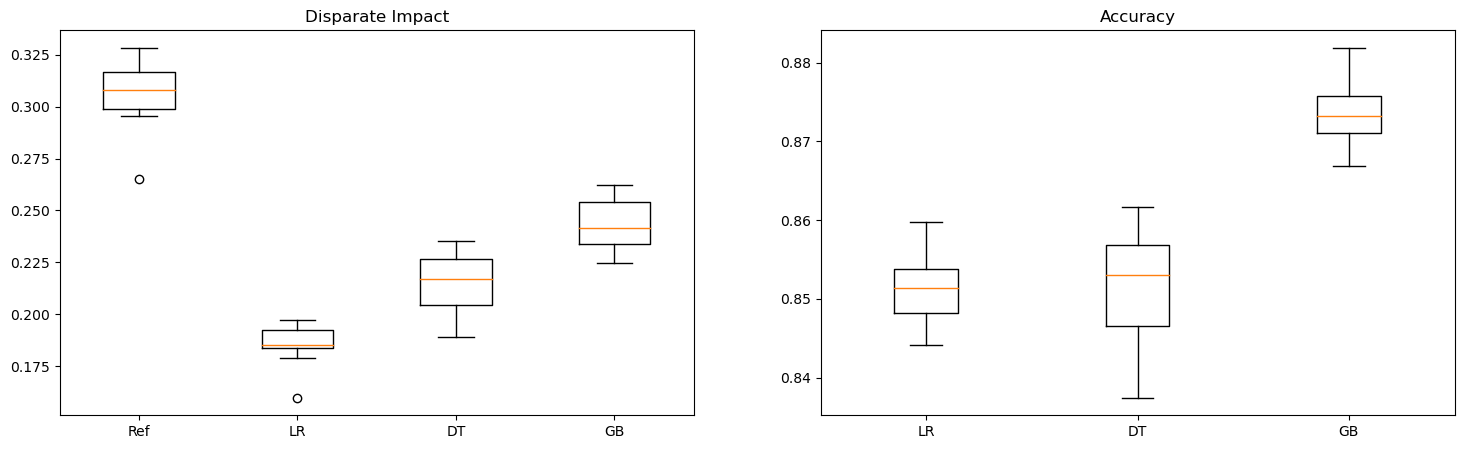

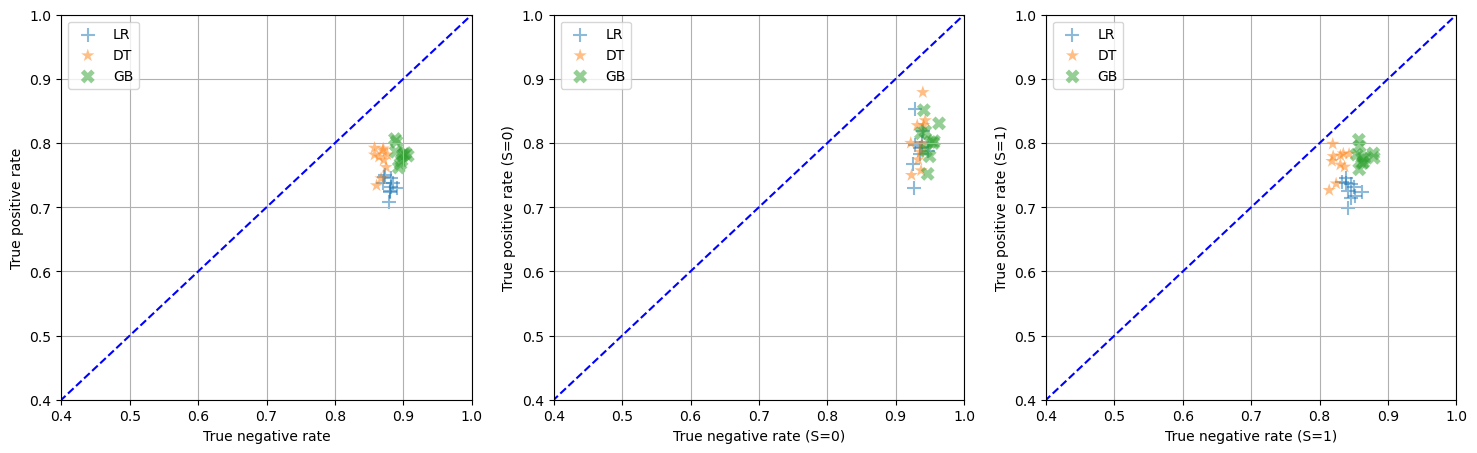

Average rates LR:
 -> True positive (all/S=0/S=1): 0.73 0.79 0.73
 -> True negative (all/S=0/S=1): 0.88 0.93 0.84
Average rates DT:
 -> True positive (all/S=0/S=1): 0.77 0.8 0.77
 -> True negative (all/S=0/S=1): 0.87 0.93 0.83
Average rates GB:
 -> True positive (all/S=0/S=1): 0.78 0.8 0.78
 -> True negative (all/S=0/S=1): 0.9 0.95 0.86
Average D.I. (Average Acc):
LR: 0.185(0.851)
DT: 0.215(0.851)
GB: 0.243(0.874)
Models trained with the positive discrimination along the sensitive variable
Known DI: 0.35965526258003366


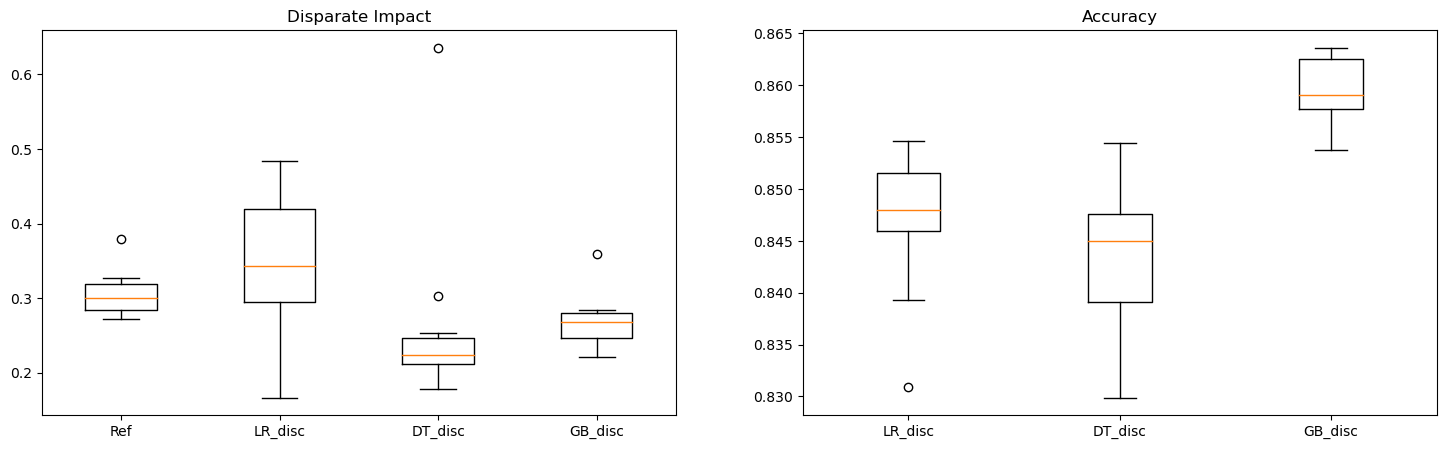

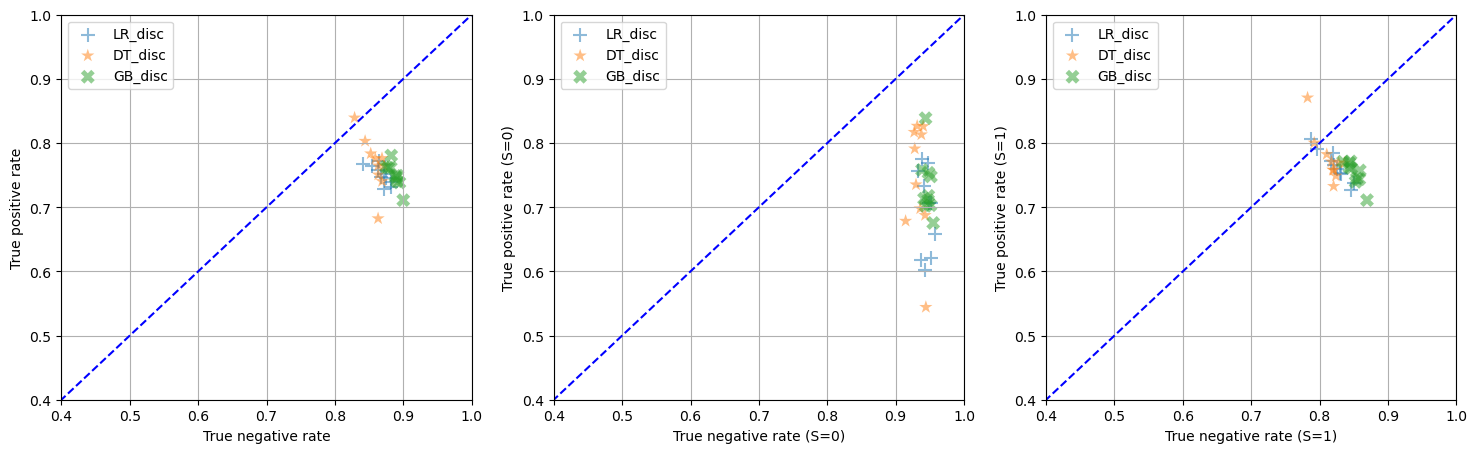

Average rates LR_disc:
 -> True positive (all/S=0/S=1): 0.75 0.69 0.76
 -> True negative (all/S=0/S=1): 0.87 0.95 0.82
Average rates DT_disc:
 -> True positive (all/S=0/S=1): 0.77 0.74 0.78
 -> True negative (all/S=0/S=1): 0.86 0.93 0.82
Average rates GB_disc:
 -> True positive (all/S=0/S=1): 0.75 0.73 0.75
 -> True negative (all/S=0/S=1): 0.89 0.95 0.85
Average D.I. (Average Acc):
LR_disc: 0.343(0.847)
DT_disc: 0.266(0.843)
GB_disc: 0.27(0.86)


In [54]:



#print("++++++++++++++++++++++++++++++++++++++++++++++++++")
#print("+            SENSITIVE VARIABLE = Sex            +")
#print("++++++++++++++++++++++++++++++++++++++++++++++++++")

S=X[:,X_col_names.index('Sex')]

clf_LR = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_DT =DecisionTreeClassifier(max_depth=5)
clf_GB = lgb.LGBMClassifier(random_state=42)
clf_NNref = SimpleNNclassifier()
clf_LR_disc = LogisticRegression(solver='lbfgs',max_iter=10000)
clf_DT_disc =DecisionTreeClassifier(max_depth=5)
clf_GB_disc = lgb.LGBMClassifier(random_state=42)
clf_NNref_disc = SimpleNNclassifier()

list_classifiers=[clf_LR ,clf_DT,clf_GB] #clf_NNref
list_classifierNames=['LR' , 'DT','GB' ] # 'NN'
nsplits=10


X_scaled=sk.preprocessing.scale(X)

PreFigNam='StandardSex'
print("Models trained without any positive discrimination")
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X_scaled,y,nsplits,printAverageRes=True,PrefixFigNames=PreFigNam, disc=0)
print("Models trained with the positive discrimination along the sensitive variable")
Make_Kfold_boxplots(list_classifiers,list_classifierNames,S,X_scaled,y,nsplits,printAverageRes=True,PrefixFigNames=PreFigNam, disc=1)

For models such as logistic regression, we manage to keep similar accuracy (84.8 % vs 85.1%) but still increasing significantly the disparate impact (27.4 vs 19.2) ang get close to the one of the existing dataset (35.9)

## Bibliography

#### Biases in dataset 'Adult Census' :
https://amstat.tandfonline.com/doi/full/10.1080/00031305.2021.1952897

https://github.com/XAI-ANITI/StoryOfBias/blob/master/StoryOfBias.ipynb

#### Reducing Biases (Zafar)
https://arxiv.org/abs/1610.08452

https://github.com/mbilalzafar/fair-classification